In [21]:
import operator
import itertools
from itertools import chain, combinations

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support

In [2]:
# Fix random seed 
np.random.seed(13)

In [3]:
behaviour_data = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv', low_memory=False)

# Drop patients with incomplete diagnosis
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their evaluation was incomplete.')

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'No Diagnosis Given', 'Communication Disorder',
                         'Depressive Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 2)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 2)]

mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their diagnoses were very uncommon.')

behaviour_data

Removing 282 patients as their evaluation was incomplete.
Removing 143 patients as their diagnoses were very uncommon.


,Anonymized.ID,EID,Sex,Age,Study.Site,NoDX,DX_01_Cat,DX_01_Sub,DX_01,DX_01_Spec,...,WISC_PSI,WISC_FSIQ,YSR_AB,YSR_AD,YSR_WD,YSR_RBB,YSR_SC,YSR_Ext,YSR_Int,YSR_Total
0,A00078864,NDARYM832PX3,1,7.048254,1,Yes,Anxiety Disorders,NaN,Generalized Anxiety Disorder,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A00078865,NDARNJ687DMC,1,6.348163,1,Yes,Depressive Disorders,NaN,Disruptive Mood Dysregulation Disorder,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A00078866,NDARRM363BXZ,0,10.052589,1,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A00078867,NDARUW586LLL,1,12.319415,1,Yes,Depressive Disorders,NaN,Major Depressive Disorder,Single episode,...,NaN,NaN,9.0,12.0,8.0,7.0,9.0,16.0,29.0,85.0
4,A00078869,NDARNH263WZP,1,15.092630,1,Yes,Depressive Disorders,NaN,Persistent Depressive Disorder (Dysthymia),NaN,...,NaN,NaN,13.0,6.0,11.0,14.0,8.0,27.0,25.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,A00093552,NDARJX939UCQ,1,10.203057,1,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,103.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1667,A00093553,NDARJJ817UP1,0,9.126397,3,Yes,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,NaN,...,100.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1668,A00093557,NDARYZ986HEW,1,7.563084,3,Yes,Neurodevelopmental Disorders,Attention-Deficit/Hyperactivity Disorder,ADHD-Combined Type,NaN,...,116.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1669,A00093558,NDARPM572ZZV,0,9.832762,3,Yes,Neurodevelopmental Disorders,Specific Learning Disorder,Specific Learning Disorder with Impairment in ...,rule out,...,98.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)

df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

classes = np.transpose(classes)
classes = np.column_stack((behaviour_data['EID'], classes))

labels = pd.DataFrame(data=classes, columns=['ID'] + most_common_disorders)
labels.set_index('ID', inplace=True)

# Remove patients that have more than one label 
exclude_IDs = []
for ID in labels.index.values: 
    if np.sum(labels.loc[ID]) > 1 or np.sum(labels.loc[ID]) == 0: 
        print('Found at ID %s' %ID)
        exclude_IDs.append(ID)
        
filtered_labels = labels[~labels.index.isin(exclude_IDs)]
filtered_labels

Found at ID NDARMF508PA2
Found at ID NDARZW873DN3


,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,No Diagnosis Given,Communication Disorder,Depressive Disorders
ID,,,,,,,,
NDARYM832PX3,0,1,0,0,0,0,0,0
NDARNJ687DMC,0,0,0,0,0,0,0,1
NDARRM363BXZ,1,0,0,0,0,0,0,0
NDARUW586LLL,0,0,0,0,0,0,0,1
NDARNH263WZP,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
NDARJX939UCQ,1,0,0,0,0,0,0,0
NDARJJ817UP1,0,0,1,0,0,0,0,0
NDARYZ986HEW,1,0,0,0,0,0,0,0


In [17]:
"""
Consider clustering based on labels. We have 8 classes (including no diagnosis given) and we would like to see 
how patients are distributed among all the possible clusters (pow(2,8) of them).
"""

X = labels[most_common_disorders].values.astype(int)

kmeans = KMeans(n_clusters=pow(2,8), n_jobs=-1)
assignments = kmeans.fit_predict(X)

/Users/adamossolomou/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (72) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  return_n_iter=True)


In [79]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [111]:
# Assign each disorder to a specific ID 
disorder_to_ID = {disorder: (i) for i,disorder in enumerate(most_common_disorders)}
ID_to_disorder = {disorder: ID for ID, disorder in disorder_to_ID.items()}

N_classes = len(most_common_disorders)
c_assignments = {key: 0 for key in list(powerset(list(range(N_classes))))}

for patient_ID in labels.index.values.tolist():
    l_array = np.where(labels.loc[patient_ID].values.astype(int) !=0)[0]
    l_tuple = tuple(l for l in l_array)
    
    # Add patient to cluster 
    c_assignments[l_tuple] += 1

In [137]:
k = 15
sorted_assignments = sorted(c_assignments.items(), key=operator.itemgetter(1), reverse=True)
top_k = sorted_assignments[:k]
top_k_values = [v[1] for v in top_k]
top_k_clusters_ = [v[0] for v in top_k]

# Convert cluster IDs to named clusters
top_k_clusters = []

for c in top_k_clusters_: 
    s = ''
    for ID in c:     
        s += ID_to_disorder[ID]+','

    top_k_clusters.append(s[:-1])

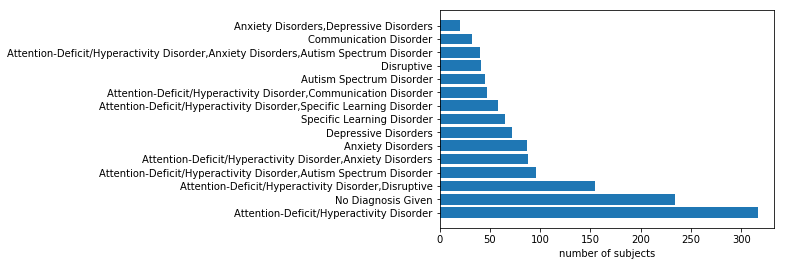

In [138]:
# Plot 
x_pos = np.arange(k)

plt.barh(x_pos, top_k_values)
plt.xlabel("number of subjects")

plt.yticks(x_pos, top_k_clusters)

plt.show()

## Clustering DX_01

In [26]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)

df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

classes = np.transpose(classes)
classes = np.column_stack((behaviour_data['EID'], classes))

labels = pd.DataFrame(data=classes, columns=['ID'] + most_common_disorders).sort_values(by='ID')
labels.set_index('ID', inplace=True)

# Remove patients that have more than one label 
exclude_IDs = []
for ID in labels.index.values: 
    if np.sum(labels.loc[ID]) > 1 or np.sum(labels.loc[ID]) == 0: 
        print('Found at ID %s' %ID)
        exclude_IDs.append(ID)
        
filtered_labels = labels[~labels.index.isin(exclude_IDs)]
filtered_labels 

Found at ID NDARMF508PA2
Found at ID NDARZW873DN3


,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,No Diagnosis Given,Communication Disorder,Depressive Disorders
ID,,,,,,,,
NDARAA075AMK,0,0,0,0,0,1,0,0
NDARAA112DMH,1,0,0,0,0,0,0,0
NDARAA117NEJ,1,0,0,0,0,0,0,0
NDARAA536PTU,1,0,0,0,0,0,0,0
NDARAA948VFH,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
NDARZY019GNZ,1,0,0,0,0,0,0,0
NDARZY101JNB,0,0,0,1,0,0,0,0
NDARZY668NMV,1,0,0,0,0,0,0,0


In [27]:
from sklearn.cluster import AgglomerativeClustering

In [28]:
n_clusters = 7
datapoints = filtered_labels.values.astype(int)
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(datapoints)

In [29]:
cluster_sets = []

for cluster_ID in range(n_clusters): 
    point_IDs = np.where(clustering.labels_ == cluster_ID)[0]
    print('Cluster ID: ', cluster_ID, ', Number of points in cluster: ', len(point_IDs))
    cluster_set = set([tuple(x) for x in datapoints[point_IDs]])
    print(cluster_set)
    cluster_sets.append(cluster_set)

Cluster ID:  0 , Number of points in cluster:  87
{(0, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1, 0)}
Cluster ID:  1 , Number of points in cluster:  789
{(1, 0, 0, 0, 0, 0, 0, 0)}
Cluster ID:  2 , Number of points in cluster:  94
{(0, 0, 0, 0, 0, 0, 0, 1)}
Cluster ID:  3 , Number of points in cluster:  188
{(0, 1, 0, 0, 0, 0, 0, 0)}
Cluster ID:  4 , Number of points in cluster:  165
{(0, 0, 0, 1, 0, 0, 0, 0)}
Cluster ID:  5 , Number of points in cluster:  112
{(0, 0, 1, 0, 0, 0, 0, 0)}
Cluster ID:  6 , Number of points in cluster:  234
{(0, 0, 0, 0, 0, 1, 0, 0)}


### Load Data 

In [15]:
fa_per_tract = pd.read_csv('data/MRI/MRI/DTI/FAPerTract.csv', low_memory=False)

# Remove "/" from the end some IDs 
fa_per_tract['ID'] = fa_per_tract['ID'].apply(lambda x: x[:-1] if "/" in x else x)
fa_per_tract = fa_per_tract.drop(columns=['ScanSite'])

# column ScanSite already exists in the behavioural data
cort_thick_l = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalThicknessLHROI.csv', low_memory=False).drop(columns=['ScanSite'])
cort_thick_r = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalThicknessRHROI.csv', low_memory=False).drop(columns=['eTIV', 'ScanSite'])
cort_vol_l = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalVolumeLHROI.csv', low_memory=False).drop(columns=['eTIV', 'ScanSite'])
cort_vol_r = pd.read_csv('data/MRI/MRI/structuralMRI/CorticalVolumeRHROI.csv', low_memory=False).drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_l = pd.read_csv('data/MRI/MRI/structuralMRI/SubCorticalVolumeLHROI.csv', low_memory=False).drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_r = pd.read_csv('data/MRI/MRI/structuralMRI/SubCorticalVolumeRHROI.csv',low_memory=False).drop(columns=['eTIV', 'ScanSite'])
glob_thick = pd.read_csv('data/MRI/MRI/structuralMRI/GlobalCorticalThickness.csv',low_memory=False).drop(columns=['ScanSite'])

# Join tables 
struct_mri = pd.merge(cort_thick_l, cort_thick_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, glob_thick, on='ID', how='inner')

eeg_mic = pd.read_csv("RestingEEG_Microstates.csv")
eeg_psd = pd.read_csv("RestingEEG_PSD_Average.csv")
eeg_spectro = pd.read_csv("RestingEEG_Spectro_Average.csv")

In [16]:
eeg_mic_ids = eeg_mic['id'].values.tolist()
eeg_psd_ids = eeg_psd['id'].values.tolist()
eeg_spectro_ids = eeg_spectro['id'].values.tolist()

inter_IDs = list(set(behaviour_data['EID'].values.tolist()) & set(struct_mri['ID'].values.tolist()) & \
        set(fa_per_tract['ID'].values.tolist()) & set(eeg_mic_ids) & set(eeg_psd_ids) & set(eeg_spectro_ids))

print('Number of patients having all data: ', len(inter_IDs))

Number of patients having all data:  392


In [48]:
filtered_labels.index.values.tolist()

ValueError: Must pass DataFrame with boolean values only

In [42]:
eeg_mri = pd.DataFrame(index=inter_IDs)

# join with behavioural data
eeg_mri = eeg_mri.join(fa_per_tract.set_index('ID'), how='inner')

eeg_mri = eeg_mri.join(struct_mri.set_index('ID'), how='inner')

eeg_mri = eeg_mri.join(eeg_mic.set_index('id'), how='inner')
eeg_mri = eeg_mri.join(eeg_psd.set_index('id'), how='inner')
eeg_mri = eeg_mri.join(eeg_spectro.set_index('id'), how='inner')
eeg_mri.sort_index(inplace=True)

eeg_mri_data = eeg_mri.values
eeg_mri_data.shape

(392, 820)

In [45]:
eeg_mri

,LeftThalamicRadiation,RightThalamicRadiation,LeftCorticospinal,RightCorticospinal,LeftCingulumCingulate,RightCingulumCingulate,LeftCingulumHippocampus,RightCingulumHippocampus,CallosumForcepsMajor,CallosumForcepsMinor,...,eyesopen_indfband_lower2alpha_absmean_average,eyesopen_indfband_lower2alpha_relmean_average,eyesopen_indfband_upperalpha_absmean_average,eyesopen_indfband_upperalpha_relmean_average,eyesopen_indfband_beta_absmean_average,eyesopen_indfband_beta_relmean_average,eyesopen_fooof_aperiodic_intercept_average,eyesopen_fooof_aperiodic_slope_average,eyesopen_fooof_peak_freq_average,eyesopen_fooof_peak_amplitude_average
NDARAA948VFH,0.440407,0.420813,0.553176,0.566157,0.442870,0.462149,NaN,NaN,0.534137,0.512610,...,1.152932,2.189390,0.725463,1.422611,0.162737,0.318368,1.346769,1.809853,7.458167,0.248691
NDARAD232HVV,0.477059,0.474047,0.560693,0.612031,NaN,NaN,NaN,NaN,0.522902,0.563851,...,2.243524,1.812043,2.152765,1.604288,0.643273,0.546265,1.306498,1.527371,9.957008,0.601509
NDARAD481FXF,0.468831,0.463561,0.630058,0.610177,0.556184,0.539246,0.385063,0.373709,0.570663,0.560004,...,0.512536,1.292825,0.719937,1.893921,0.214072,0.552552,1.104170,1.670872,11.205861,0.531823
NDARAD615WLJ,0.321736,0.385354,0.457649,0.465786,NaN,NaN,0.329186,0.329553,NaN,0.439639,...,1.195865,1.687811,0.870031,1.230991,0.260767,0.374777,1.392815,1.700319,10.134594,0.267556
NDARAE199TDD,0.454129,0.449482,0.573924,0.624328,0.557579,0.477337,0.390085,NaN,NaN,0.580059,...,1.891262,1.637382,1.346960,1.145003,0.698196,0.603112,1.721644,1.879612,8.545579,0.299401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDARZV766YXP,0.403322,0.431578,0.644600,0.671288,0.566557,0.503248,0.365934,0.376979,0.587754,0.562468,...,0.650012,1.684259,0.638547,1.664131,0.114587,0.306137,1.350018,1.889496,10.501207,0.492171
NDARZW013RUH,NaN,0.422926,0.532944,0.494349,0.353030,0.421294,NaN,NaN,0.644201,0.558538,...,2.352361,2.175878,1.484920,1.389322,0.251173,0.243892,1.520444,1.731433,5.374482,0.238371
NDARZW472CCF,0.445741,0.496935,0.520404,0.497049,NaN,NaN,NaN,NaN,0.606643,0.566425,...,3.035290,1.969332,3.476686,2.144650,0.565212,0.362671,1.766349,1.840908,10.759136,0.684934
NDARZW930MF2,0.399457,0.383633,0.526873,0.498594,0.340887,NaN,NaN,0.409829,0.570211,0.548486,...,1.102861,1.672537,0.659410,0.975755,0.259101,0.377552,1.579293,1.845948,7.604260,0.169495


In [22]:
from sklearn.metrics import balanced_accuracy_score

def mean_imputer(x, y):
    return np.where(np.isnan(x), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), x),\
            np.where(np.isnan(y), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), y)  

def run_cross_validation(data, classes, classifier, n_splits=5, verbose=1, scaler=MinMaxScaler()):
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    kf.get_n_splits(data)

    final_predictions = np.zeros(classes.shape)

    # split
    for train_index, test_index in kf.split(data):
        train, test = data[train_index], data[test_index]
        train_classes, test_classes = classes[train_index], classes[test_index]

        train, test = mean_imputer(train, test)

        train = scaler.fit_transform(train)
        test = scaler.transform(test)

        classifier.fit(train, train_classes)
        final_predictions[test_index] = classifier.predict(test)

    final_predictions = final_predictions.astype(np.int16)

    if verbose:
        print_metrics(classes, final_predictions)
    
    return final_predictions, balanced_accuracy_score(classes, final_predictions)

def print_metrics(true, predictions):
    print('balanced_accuracy_score', balanced_accuracy_score(true, predictions))

In [44]:
labels_from_clusters = pd.Series(data=clustering.labels_, index=filtered_labels.index, dtype=int)
labels_from_clusters = labels_from_clusters.loc[inter_IDs]
labels_from_clusters.sort_index(inplace=True)
labels_from_clusters

ID
NDARAA948VFH    1
NDARAD232HVV    4
NDARAD481FXF    2
NDARAD615WLJ    1
NDARAE199TDD    1
               ..
NDARZV766YXP    1
NDARZW013RUH    1
NDARZW472CCF    1
NDARZW930MF2    3
NDARZZ740MLM    1
Length: 392, dtype: int64

In [47]:
clf = SVC(gamma='auto', C=1, class_weight='balanced')

svm_ = run_cross_validation(eeg_mri_data, labels_from_clusters, clf, scaler=StandardScaler())

balanced_accuracy_score 0.19156953103822175


In [46]:
clf = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced')

rf_ = run_cross_validation(eeg_mri_data, labels_from_clusters, clf, scaler=StandardScaler())

balanced_accuracy_score 0.1607931122921635
